In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_04 import *
from functools import partial

## Initial setup

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
loss_func = F.cross_entropy

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [ ]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.30797775390625, tensor(0.9052)]
valid: [0.2243966796875, tensor(0.9343)]
train: [0.1430846875, tensor(0.9563)]
valid: [0.1217243896484375, tensor(0.9646)]
train: [0.105280712890625, tensor(0.9682)]
valid: [0.10170741577148437, tensor(0.9691)]


In [ ]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.3463105078125, tensor(0.8965)]
valid: [0.170680517578125, tensor(0.9519)]
train: [0.161000263671875, tensor(0.9521)]
valid: [0.1534656982421875, tensor(0.9549)]
train: [0.11951298828125, tensor(0.9648)]
valid: [0.1204710693359375, tensor(0.9648)]


In [ ]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)

## Annealing

In [ ]:
class Recorder(Callback):
    def begin_fit(self, run):
        run.lrs=[]
        run.losses=[]
        run.stats=[]

    def after_batch(self, run):
        if run.in_train:
            run.lrs.append(run.opt.param_groups[-1]['lr'])
            run.losses.append(run.loss)        

In [ ]:
def plot_lr  (run): plt.plot(run.lrs)
def plot_loss(run): plt.plot(run.losses)

In [ ]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self, run):
        for pg in run.opt.param_groups:
            pg[self.pname] = self.sched_func(run.n_epochs/run.epochs)
            
    def begin_batch(self, run): 
        if run.is_train: self.set_param(run)

In [ ]:
def sched_lin_val(start, end, pos): return start + pos*(end-start)
def sched_lin(start, end): return partial(sched_lin_val, start, end)
def sched_cos_val(start, end, pos): return start + math.cos(math.pi*pct/2.)*(end-start)
def sched_cos(start, end): return partial(sched_cos_val, start, end)

In [ ]:
import numpy as np

In [ ]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    assert np.all(np.array(pcts) >= 0)
    pcts = np.cumsum([0] + pcts)
    def _inner(pos):
        idx = (pos >= pcts).nonzero()[0].max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.1, 0.5), sched_lin(0.5, 0.1)]) 

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner([Recorder(), AvgStatsCallback([accuracy]), ParamScheduler('lr', sched)]) #sched_lin(0.5,0.1))])

In [ ]:
run.fit(1, learn)

train: [0.40052296875, tensor(0.8847)]
valid: [0.15908463134765624, tensor(0.9555)]


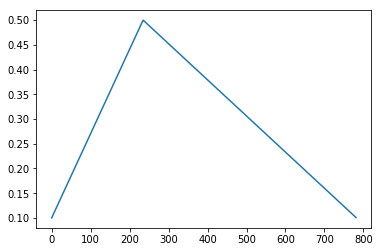

In [ ]:
plot_lr(run)

## Export

In [ ]:
!./notebook2script.py 05_more_callbacks.ipynb

Converted 05_more_callbacks.ipynb to nb_05.py
